In [26]:
pip install ripser

Note: you may need to restart the kernel to use updated packages.


In [27]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [28]:
# load the data
df = pd.read_csv(
    'https://www.dropbox.com/scl/fi/1hpq7fymf2syrhwtrb59u/concepts_Applied-Mathematics_102.csv.gz?rlkey=i0s1wyaeww3ngwsc6o9vdwbye&st=920x22gz&raw=1',
    compression='gzip'
)

df


,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1011927506,2001,abi raising standards scheme,0.0,1,0,1,1
1,pub.1091536887,1988,attu conventional arm control forum,0.0,1,0,1,1
2,pub.1127413625,1997,av 8 harrier,0.0,1,0,1,1
3,pub.1021705670,2010,advertisement game strategy,0.0,1,0,1,1
4,pub.1058195248,1984,aramovich aleksandryan,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...
26399751,pub.1015682740,2008,’s ψ11 summation formula,0.0,1,29,1,1
26399752,pub.1140295407,2021,’ ω transform,0.0,1,4,1,1
26399753,pub.1039011473,2010,’ ϵ variational principle,0.0,1,32,1,1
26399754,pub.1128915375,2020,′ | z | 2 d,0.0,1,16,1,1


In [29]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
46607,pub.1110525015,ad hoc networks,2018
46609,pub.1061389704,ad hoc networks,2009
46610,pub.1128617440,ad hoc networks,2020
46611,pub.1103595830,ad hoc networks,2018
46612,pub.1053051088,ad hoc networks,2013
...,...,...,...
26376853,pub.1024144862,zero sum stochastic differential game,2008
26376854,pub.1122600451,zero sum stochastic differential game,2019
26376855,pub.1072010385,zero sum stochastic differential game,2012
26376856,pub.1092410835,zero sum stochastic differential game,2017


In [30]:
# get the initial publication
concepts = (
        df
            .sort_values('year')  # sort so earliest year is first
            .groupby('concept')
            .agg(
                year=('year', 'min'),
                count=('article_id', 'nunique')
            )
            .reset_index()
    )

# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
concepts['inv_count'] = 1 / np.log1p(concepts['count'])

concepts

,concept,year,count,norm_year,inv_count
0,abstract differential equation,1956,32,0.356436,0.286000
1,abstract evolution equations,1972,22,0.514851,0.318929
2,accurate mathematical model,1961,84,0.405941,0.225091
3,accurate numerical solution,1966,24,0.455446,0.310667
4,acoustic emission,2011,27,0.900990,0.300102
...,...,...,...,...,...
4596,zero coupon bond,1995,19,0.742574,0.333808
4597,zero order hold,1970,38,0.495050,0.272958
4598,zero sum differential game,1971,59,0.504950,0.244239
4599,zero sum game,1982,35,0.613861,0.279055


In [31]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
# edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
edges = edges.groupby(['concept_source', 'concept_target']).agg(
        year=('year', 'min'),
        count=('article_id', 'nunique')
    ).reset_index()

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
edges['inv_count'] = 1 / np.log1p(edges['count'])

edges

,concept_source,concept_target,year,count,norm_year,inv_count
0,abstract differential equation,approximate controllability,2000,1,0.792079,1.442695
1,abstract differential equation,approximation of solution,1973,1,0.524752,1.442695
2,abstract differential equation,banach space,2016,1,0.950495,1.442695
3,abstract differential equation,boundary control problem,1988,1,0.673267,1.442695
4,abstract differential equation,boundary control system,2013,2,0.920792,0.910239
...,...,...,...,...,...,...
141164,yang mills,yang mills theory,1987,4,0.663366,0.621335
141165,yang mills equation,yang mills theory,1984,4,0.633663,0.621335
141166,zero sum differential game,zero sum game,2018,2,0.970297,0.910239
141167,zero sum differential game,zero sum stochastic differential game,1995,2,0.742574,0.910239


###Processing the Crocker###

In [32]:
# initialize the graph
G = nx.Graph()

# add the nodes
G.add_nodes_from([(c, {'norm_year': ny, 'inv_count': ic}) for c, ny, ic in zip(concepts['concept'], concepts['norm_year'], concepts['inv_count'])])

# add the edges
G.add_edges_from([(u, v, {'norm_year': ny, 'inv_count': ic}) for u, v, ny, ic in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'], edges['inv_count'])])

G

In [33]:
import oat_python as oat

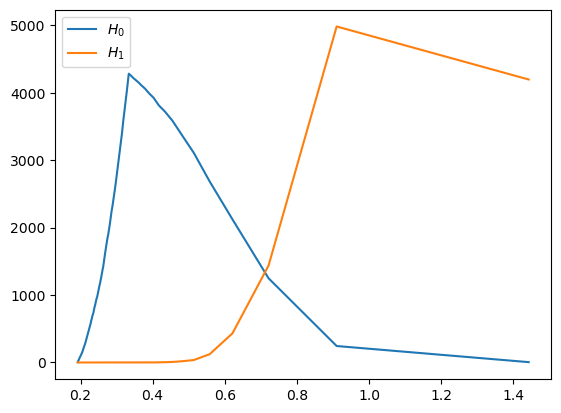

In [34]:
# config
max_dim = 1

# setup crocker
adj_year = nx.adjacency_matrix(G, weight='norm_year')
adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
adj_inv_count = adj_inv_count.sorted_indices()

# run crocker
years = np.unique(adj_year.data)
inv_counts = np.unique(adj_inv_count.data)
betti_curves = np.empty((len(years), len(inv_counts), max_dim + 1))
for i, y in enumerate(years):
    # zero out things not included
    y_adj = adj_inv_count.copy()
    y_adj[adj_year > y] = 0
    y_adj.eliminate_zeros()

    # calcaulte homology
    factored = oat.rust.FactoredBoundaryMatrixVr(y_adj, max_dim)
    homology = factored.homology(False, False)

    # create betti curve
    for d in range(max_dim + 1):
        dim_homology = homology[homology['dimension'] == d]  # get teh right dimensional features
        betti_curves[i, :, d] = ((dim_homology['birth'].values <= inv_counts[:, None]) &
                                (dim_homology['death'].values > inv_counts[:, None])).sum(axis=1)

plt.plot(inv_counts, betti_curves[-1], label=['$H_0$', '$H_1$'])
plt.legend()

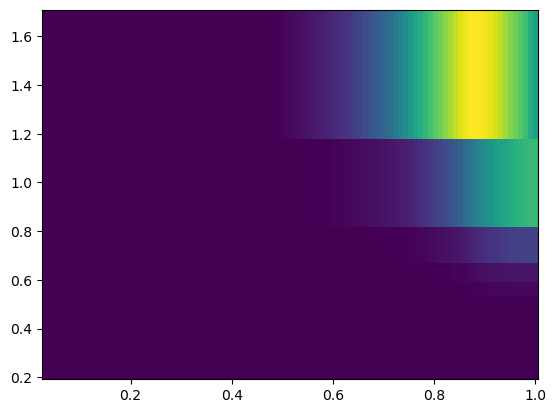

In [35]:
cb = plt.pcolormesh(years, inv_counts, betti_curves[:, :, 1].T, shading='auto', cmap='viridis')
plt.show()

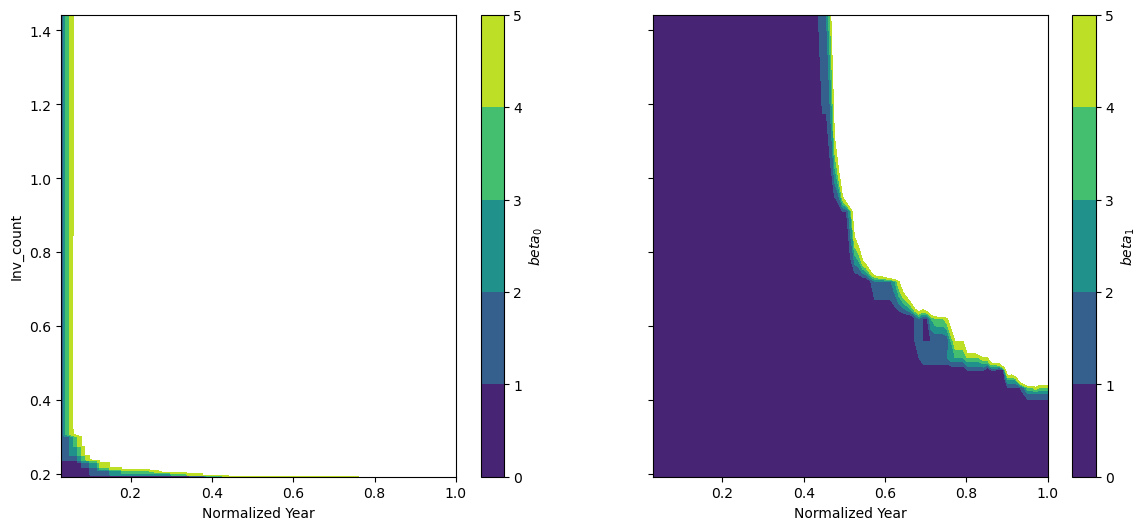

In [36]:
X, Y = np.meshgrid(years, inv_counts)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for dim, ax in enumerate(axs):
    Z = betti_curves[:, :, dim].T
    cp = ax.contourf(X, Y, Z, levels=np.arange(0, 6), cmap='viridis')
    fig.colorbar(cp, ax=ax, label=f"$beta_{dim}$")
    ax.set_xlabel("Normalized Year")

axs[0].set_ylabel("Inv_count")
plt.show()

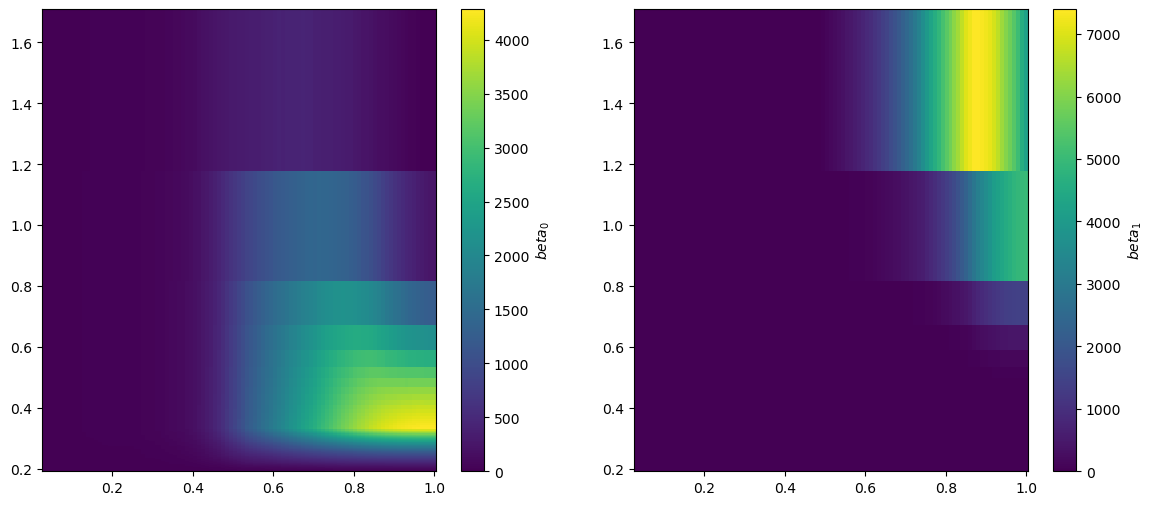

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for dim, ax in enumerate(axs):
    Z = betti_curves[:, :, dim].T
    cb = ax.pcolormesh(years, inv_counts, Z, shading='auto', cmap='viridis')
    fig.colorbar(cb, ax=ax, label=f"$beta_{dim}$")
plt.show()

In [38]:
print("years =", years)
print("inv_counts =", inv_counts)
print("betti_curves.shape =", betti_curves.shape)


years = [0.02970297 0.03960396 0.04950495 0.06930693 0.07920792 0.0990099
 0.11881188 0.12871287 0.13861386 0.14851485 0.15841584 0.16831683
 0.17821782 0.1980198  0.23762376 0.24752475 0.25742574 0.26732673
 0.27722772 0.28712871 0.2970297  0.31683168 0.32673267 0.33663366
 0.34653465 0.35643564 0.36633663 0.37623762 0.38613861 0.3960396
 0.40594059 0.41584158 0.42574257 0.43564356 0.44554455 0.45544554
 0.46534653 0.47524752 0.48514851 0.4950495  0.5049505  0.51485149
 0.52475248 0.53465347 0.54455446 0.55445545 0.56435644 0.57425743
 0.58415842 0.59405941 0.6039604  0.61386139 0.62376238 0.63366337
 0.64356436 0.65346535 0.66336634 0.67326733 0.68316832 0.69306931
 0.7029703  0.71287129 0.72277228 0.73267327 0.74257426 0.75247525
 0.76237624 0.77227723 0.78217822 0.79207921 0.8019802  0.81188119
 0.82178218 0.83168317 0.84158416 0.85148515 0.86138614 0.87128713
 0.88118812 0.89108911 0.9009901  0.91089109 0.92079208 0.93069307
 0.94059406 0.95049505 0.96039604 0.97029703 0.98019802 

In [39]:
def plot_crocker(years, inv_counts, betti_curves):
    import numpy as np
    import matplotlib.pyplot as plt

    X, Y = np.meshgrid(years, inv_counts)
    fig, axs = plt.subplots(1, betti_curves.shape[2], figsize=(7 * betti_curves.shape[2], 6), sharey=True)

    if betti_curves.shape[2] == 1:
        axs = [axs]

    for dim, ax in enumerate(axs):
        Z = betti_curves[:, :, dim].T
        cp = ax.contourf(X, Y, Z, levels=np.arange(0, 6), cmap='viridis')
        fig.colorbar(cp, ax=ax, label=f"$\\beta_{dim}$")
        ax.set_title(f"CROCKER Plot for $\\beta_{dim}$")
        ax.set_xlabel("Normalized Year $t$")
        if dim == 0:
            ax.set_ylabel("Inverse Concept Frequency $1/\\mathrm{{count}}$")

    plt.tight_layout()
    plt.show()


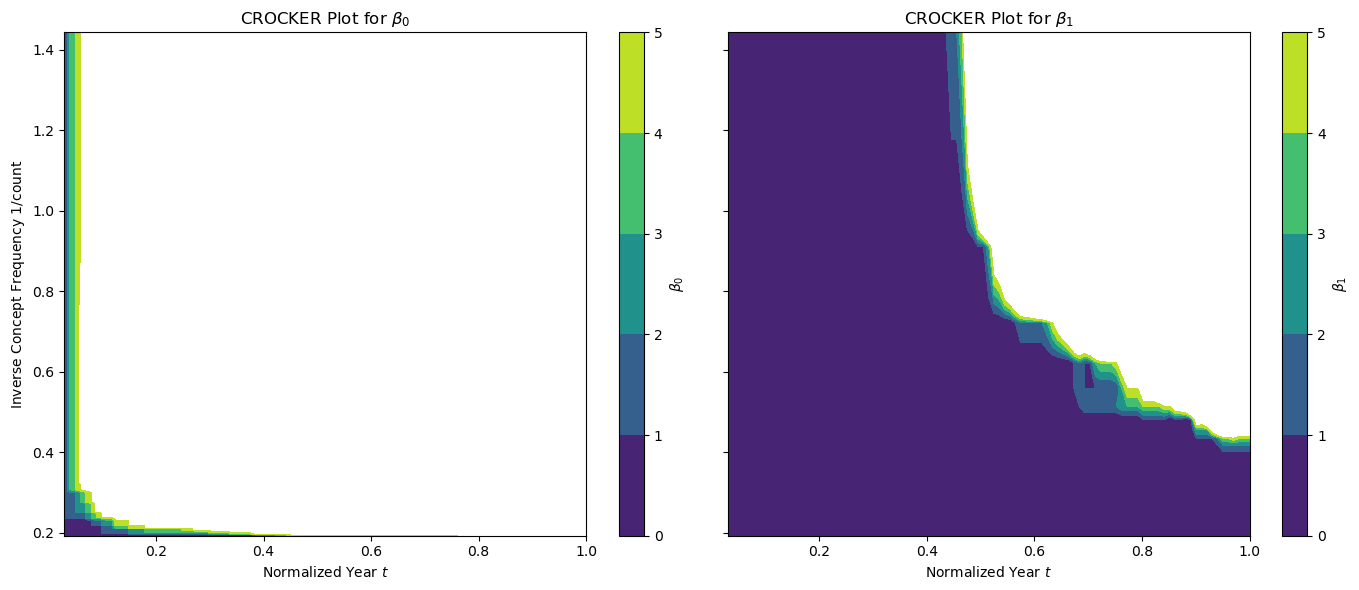

In [40]:
plot_crocker(years, inv_counts, betti_curves)